# **Import libraries**

In [9]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sps
import matplotlib.pyplot as plt
import louvain
import igraph as ig
import time
import pickle

In [10]:
from bertopic import BERTopic

# **Load functions for probability matrices**

In [11]:
#%run ../labs/communities_mod.py

In [12]:
%run "communities_mod.ipynb"

bertopic 1.11
softlouvain v1.10


# **Load Reddit data**

In [13]:
in_dir = ""
in_file = "reddit_titles"

# load word occurrences
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

# **Visualize the degree distribution of words and documents**

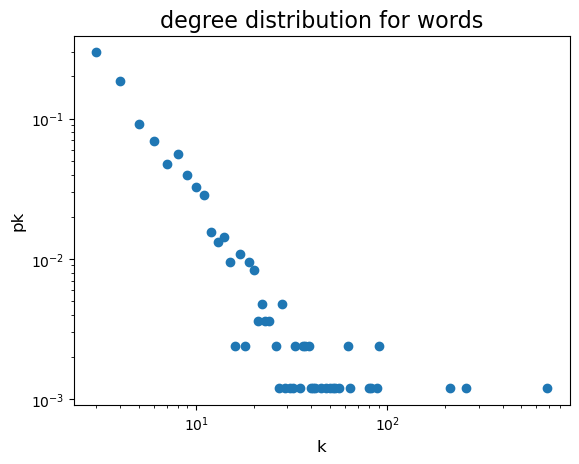

In [14]:
# degree distribution for words
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

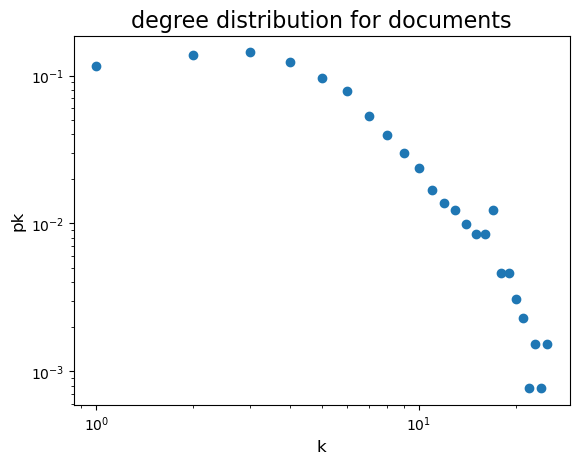

In [15]:
# degree distribution for documents
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [16]:
# assignment for the class: evaluate the gamma slope for documents and words
# are we observing scale-free networks?

# **Build probability matrices from words occurrences**

In [17]:
# remove elements that are too central, e.g., #covid19
# remove documents and words with fewer than 2 links
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

removing: israel PROPN  


In [8]:
# build probability matrices
# set tform=True for TF-IDF matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

# **Assign documents to topics using Louvain**
i.e., run Louvain community detection on Pdd

In [24]:
# start a time counter
tic = time.time()

# build a graph based on Pdd as adjacency matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# run Louvain on the graph to get a partition
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# function to map the partition into a community assignment matrix C
# where rows represent documents, and columns represent topics
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# map the partition into a community assignment matrix C
C_l = partition_to_C(part)

# capture execution time
et_louv = time.time()-tic

# refine with soft Louvain
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# capture execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



[1196, 1196]
140.00714267493635
53.740115370177584
14.142135623730955
35.355339059327385
12.727922061357859
1.4142135623730951
0.0
[1196, 26]
5.656854249492381
0.0
[1196, 24]
0.0


# **Assign documents to topics using BERTopic**
i.e., run BERTopic detection on superficially cleaned text

In [10]:
# load text
df2 = pd.read_excel(in_dir+in_file+"_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# remove those documents that do not appear in Pcc
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# workaround to reinsert hashtags (if any) in the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [11]:
# start a time counter
tic = time.time()

# prepare a BERTopic instance
bert_model = BERTopic()

# run BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# reduce the number of topics only in case it is needed!
# topics = bert_model.reduce_outliers(docs, topics)

# function to map the topis into a community assignment matrix C
# where rows represent documents, and columns represent topics
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# map the topics into a community assignment matrix C
C_b = topics_to_C(topics)

# capture execution time
et_bert = time.time()-tic

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# **Evaluate NMI, modulartity, Ncut, and Infomap metrics**

In [25]:
# prepare a template dataframe for collecting the results
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# identify the infomap ranking vector
r = infomap_rank(Pdd)

In [26]:
# hard Louvain: evaluate the statistics of interest
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# soft Louvain: evaluate the statistics of interest
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# BERTopic: evaluate the statistics of interest
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [27]:
# display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,reddit_titles,hard Louvain Pdd,0.793420,26,0.546893,0.375180,0.581499,-0.008123
1,reddit_titles,soft Louvain Pdd,9.176213,24,0.545248,0.377335,0.576488,-0.007135
2,reddit_titles,BERTopic,43.620751,2,0.539885,0.003926,0.392286,0.001886


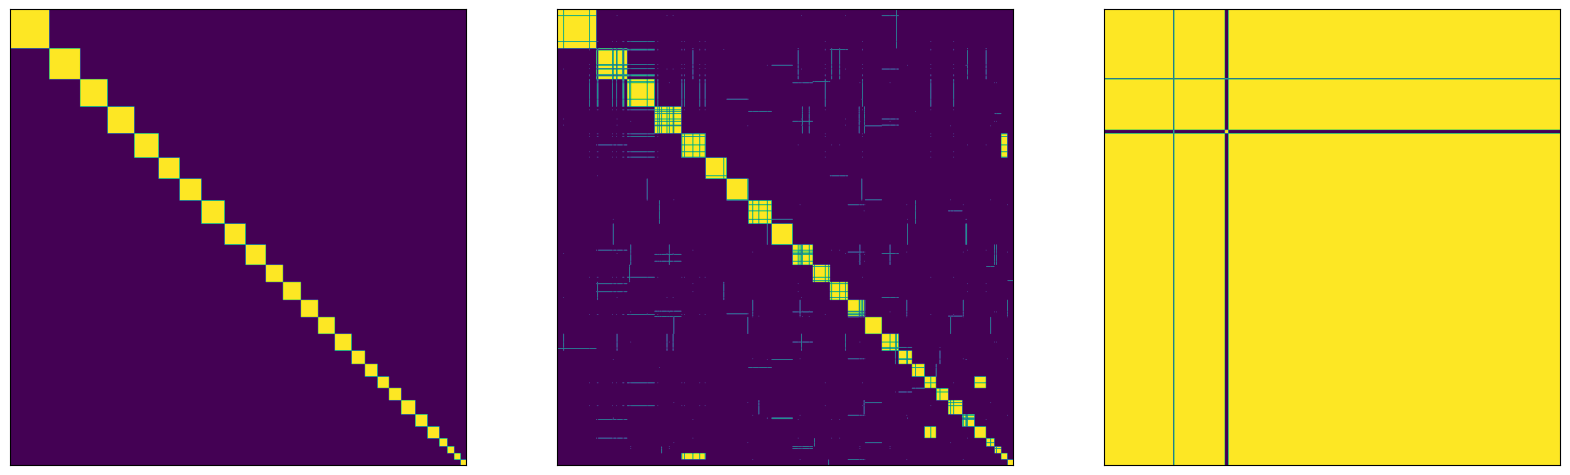

In [28]:
# show community patterns and their relations
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

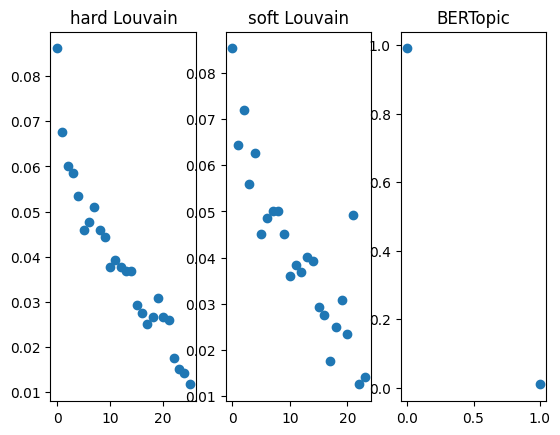

In [30]:
# show number of documents per community
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

# **Visualize the result using BERTopic tools**

In [31]:
# Louvain first

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# visualize topic description
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [23]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")